<h3 style="color:darkblue;">Satellite-Enabled Precision Agriculture: Machine Learning Classification of Cropland Using Sentinel-2 Imagery</h3>

<h4 style="color:darkred;">Data Libraries and a Quick Lookup</h4>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the exported CSV from GEE
df = pd.read_csv("BrongAhafo_TrainData_2023.csv")

df.head()  # Quick check to see first rows

,system:index,B11,B12,B2,B3,B4,B8,class,.geo
0,1_0_0,0.37450,0.26760,0.15805,0.1856,0.17815,0.42060,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_0,0.30300,0.19720,0.14550,0.1804,0.15680,0.48480,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_2_0,0.30090,0.19605,0.11680,0.1535,0.12990,0.46520,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_3_0,0.37850,0.26630,0.16540,0.2001,0.17940,0.43000,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_4_0,0.34515,0.22140,0.14360,0.1728,0.14760,0.54145,1,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [3]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  600 non-null    object 
 1   B11           600 non-null    float64
 2   B12           600 non-null    float64
 3   B2            600 non-null    float64
 4   B3            600 non-null    float64
 5   B4            600 non-null    float64
 6   B8            600 non-null    float64
 7   class         600 non-null    int64  
 8   .geo          600 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 42.3+ KB


In [4]:
# Drop irrelevant columns (system:index, .geo)
df = df.drop(columns=['system:index', '.geo'], errors='ignore')

In [5]:
# Basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())

Dataset Shape: (600, 7)

Column Names: ['B11', 'B12', 'B2', 'B3', 'B4', 'B8', 'class']


In [6]:
# Check for missing values
print("Missing Values:")
df.isnull().sum()

Missing Values:


B11      0
B12      0
B2       0
B3       0
B4       0
B8       0
class    0
dtype: int64

<h4 style="color:darkred;">Exploratory Data Analysis - EDA</h4>

Class Distribution:
class
1    300
0    300
Name: count, dtype: int64


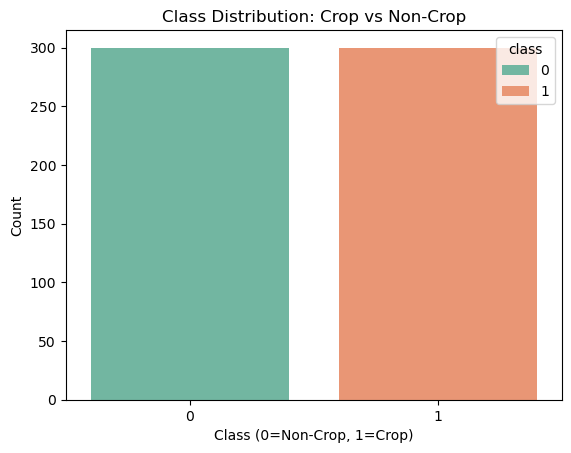

In [7]:
# Check class distribution (0 = non-crop, 1 = crop)
print("Class Distribution:")
print(df['class'].value_counts())

sns.countplot(x='class', data=df, hue = 'class', palette='Set2')
plt.title("Class Distribution: Crop vs Non-Crop")
plt.xlabel("Class (0=Non-Crop, 1=Crop)")
plt.ylabel("Count")
plt.show()

In [8]:
# Statistical summary of spectral bands
print("Statistical Summary of Spectral Bands:")
df.describe()

Statistical Summary of Spectral Bands:


,B11,B12,B2,B3,B4,B8,class
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.380196,0.300256,0.232792,0.254753,0.246535,0.446892,0.500000
std,0.104582,0.108211,0.148905,0.130591,0.129796,0.121122,0.500417
min,0.120600,0.119400,0.107200,0.132350,0.120600,0.107300,0.000000
25%,0.314763,0.214850,0.140588,0.173500,0.150375,0.381950,0.000000
50%,0.359850,0.251800,0.165525,0.197500,0.185500,0.451850,0.500000
75%,0.441312,0.385887,0.238275,0.264300,0.299500,0.505337,1.000000
max,0.807800,0.723500,0.865600,0.781400,0.762000,0.816200,1.000000


In [9]:
# Separate statistics by class
print("Crop Class (1) Statistics:")
df[df['class'] == 1].describe()

Crop Class (1) Statistics:


,B11,B12,B2,B3,B4,B8,class
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.0
mean,0.329612,0.225748,0.144152,0.176640,0.154882,0.466756,1.0
std,0.033285,0.030628,0.017530,0.016900,0.017628,0.047508,0.0
min,0.240700,0.161800,0.107200,0.138500,0.123600,0.331000,1.0
25%,0.303375,0.204350,0.133375,0.166362,0.142300,0.434000,1.0
50%,0.328950,0.221600,0.141175,0.174750,0.152675,0.466025,1.0
75%,0.348838,0.242750,0.149600,0.184500,0.165675,0.496925,1.0
max,0.428200,0.356900,0.245400,0.257200,0.222200,0.645400,1.0


In [10]:
print("Non-Crop Class (0) Statistics:")
df[df['class'] == 0].describe()

Non-Crop Class (0) Statistics:


,B11,B12,B2,B3,B4,B8,class
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.0
mean,0.430779,0.374765,0.321432,0.332866,0.338188,0.427029,0.0
std,0.125176,0.106679,0.168362,0.147090,0.128775,0.162300,0.0
min,0.120600,0.119400,0.127900,0.132350,0.120600,0.107300,0.0
25%,0.388912,0.332775,0.197700,0.226475,0.253125,0.334738,0.0
50%,0.441375,0.386075,0.238050,0.264400,0.299800,0.386375,0.0
75%,0.516112,0.444400,0.456975,0.444100,0.431812,0.564600,0.0
max,0.807800,0.723500,0.865600,0.781400,0.762000,0.816200,0.0


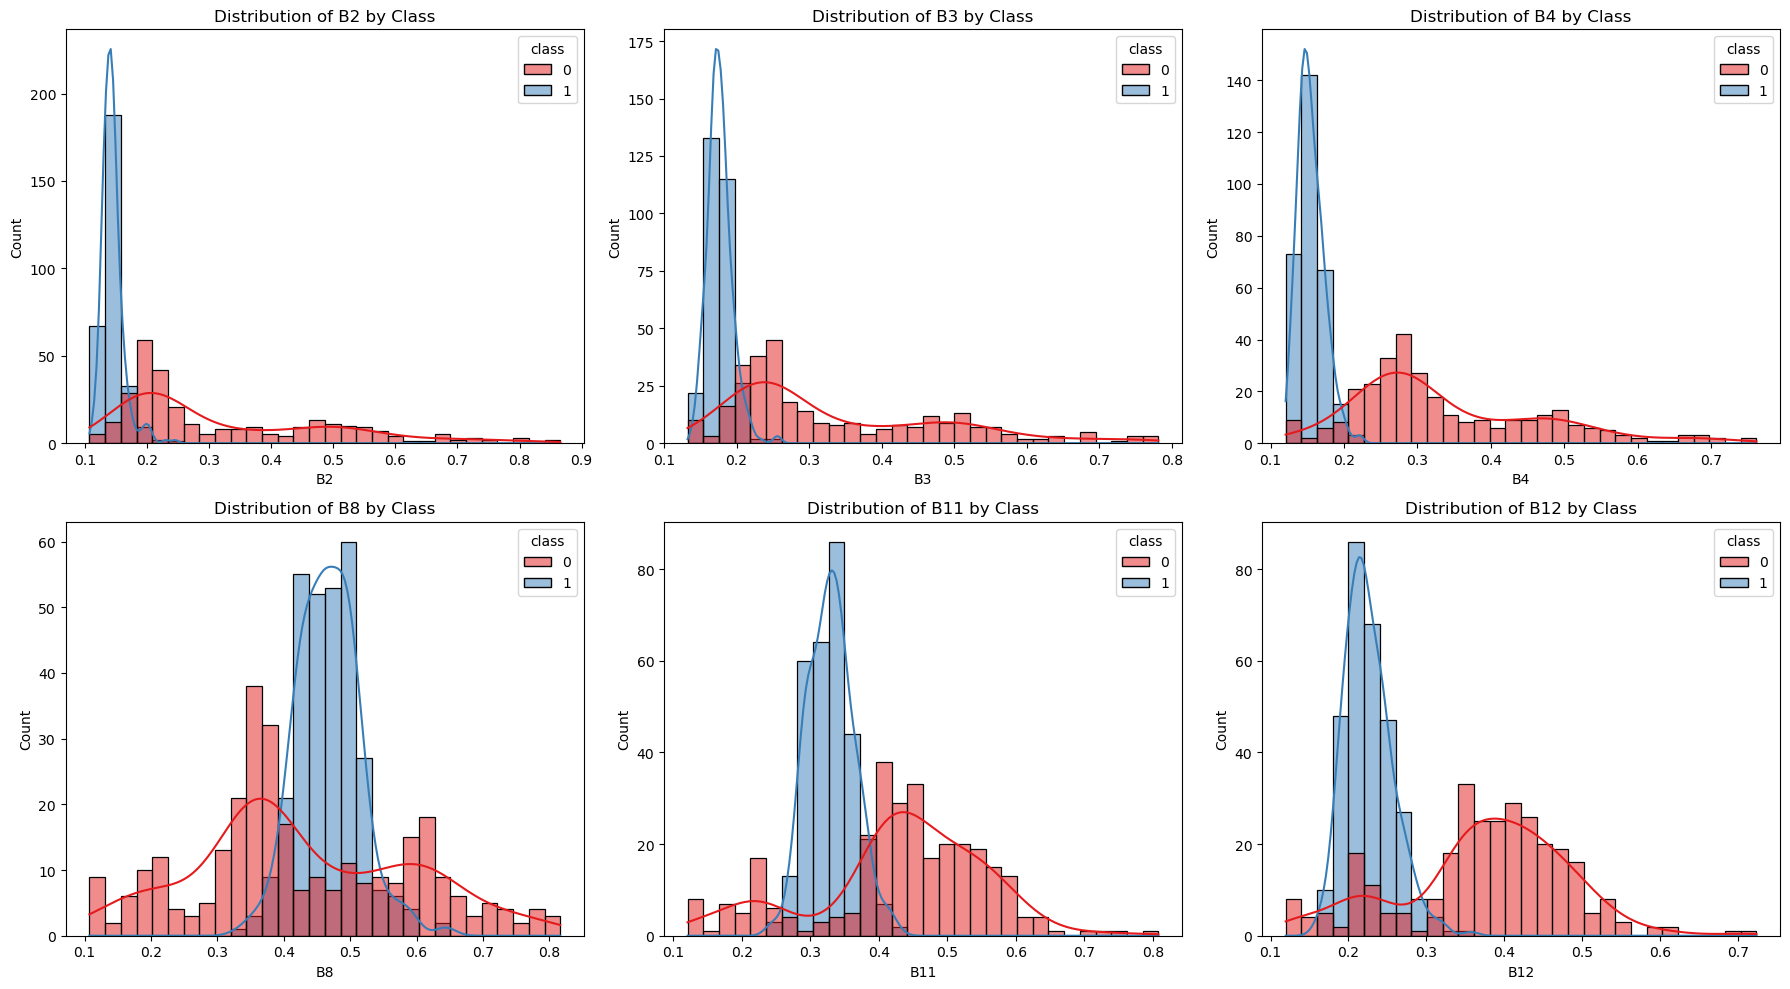

In [11]:
# Distribution of each Sentinel-2 band by class
# List of bands
bands = ['B2','B3','B4','B8','B11','B12']

# Set up the subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through bands
for i, band in enumerate(bands):
    ax = axes[i]
    sns.histplot(data=df, x=band, hue="class", bins=30, kde=True, palette="Set1", ax=ax)
    ax.set_title(f"Distribution of {band} by Class")

# Adjust layout
plt.tight_layout()
plt.show()

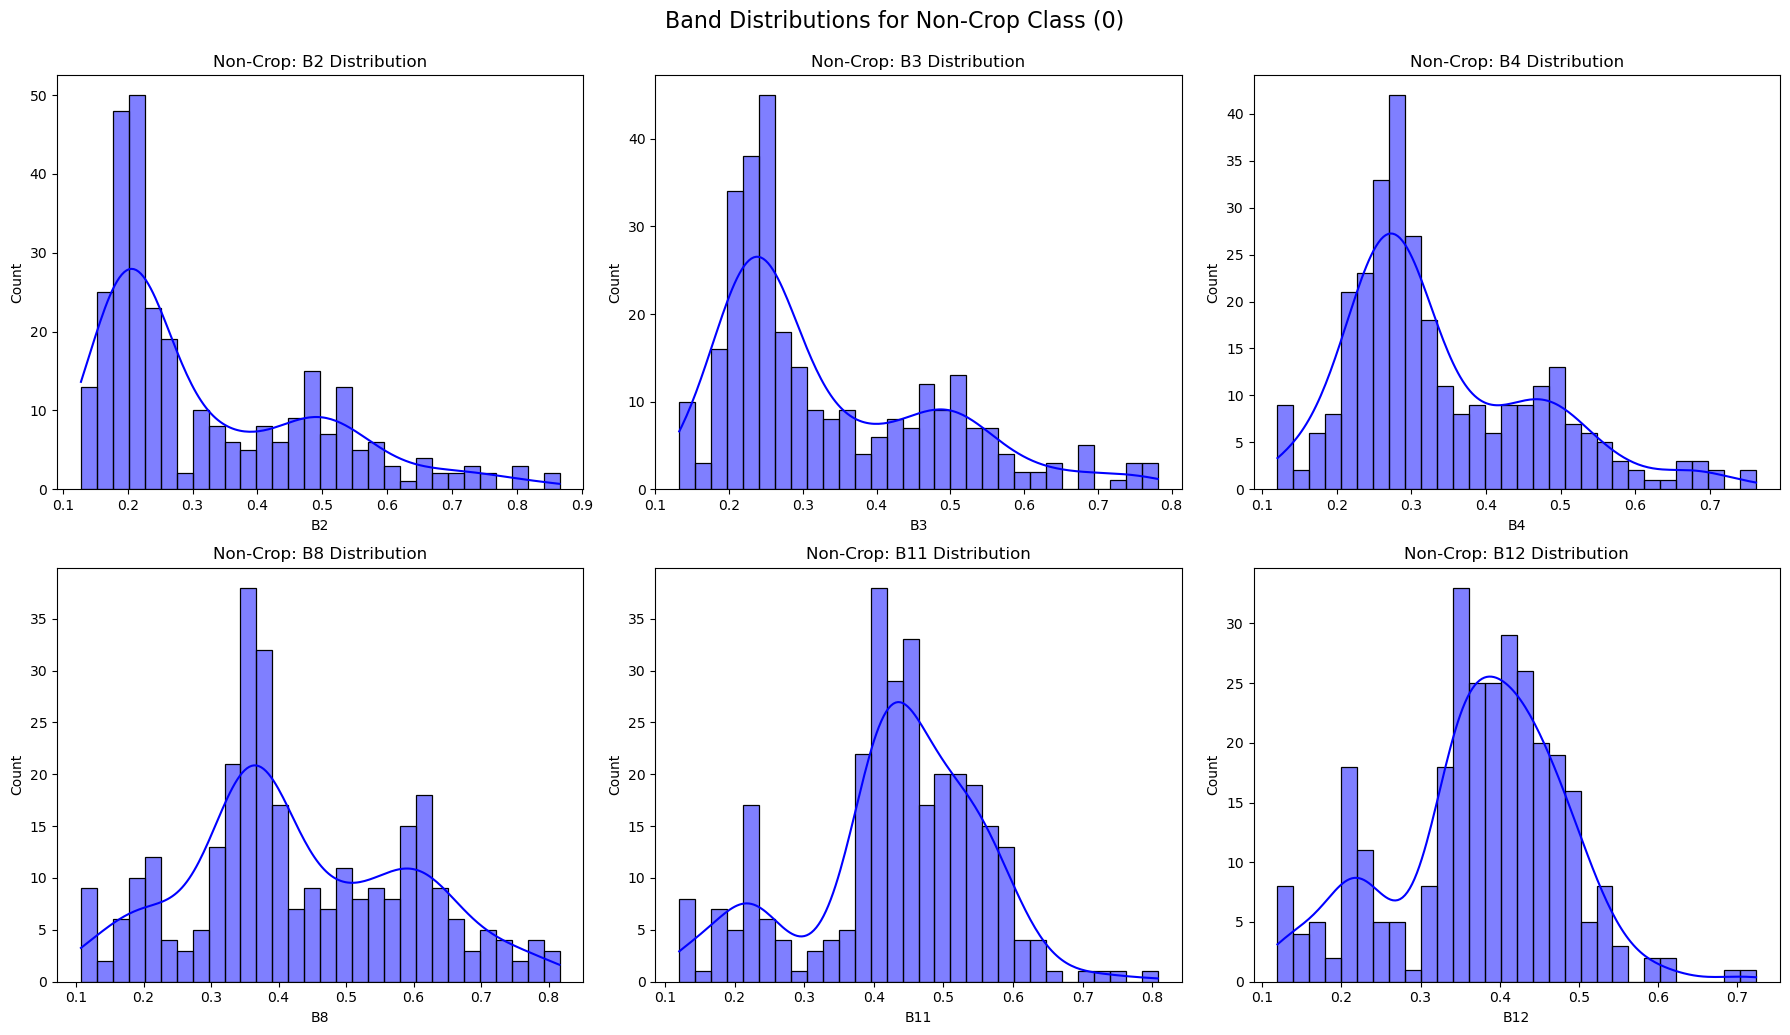

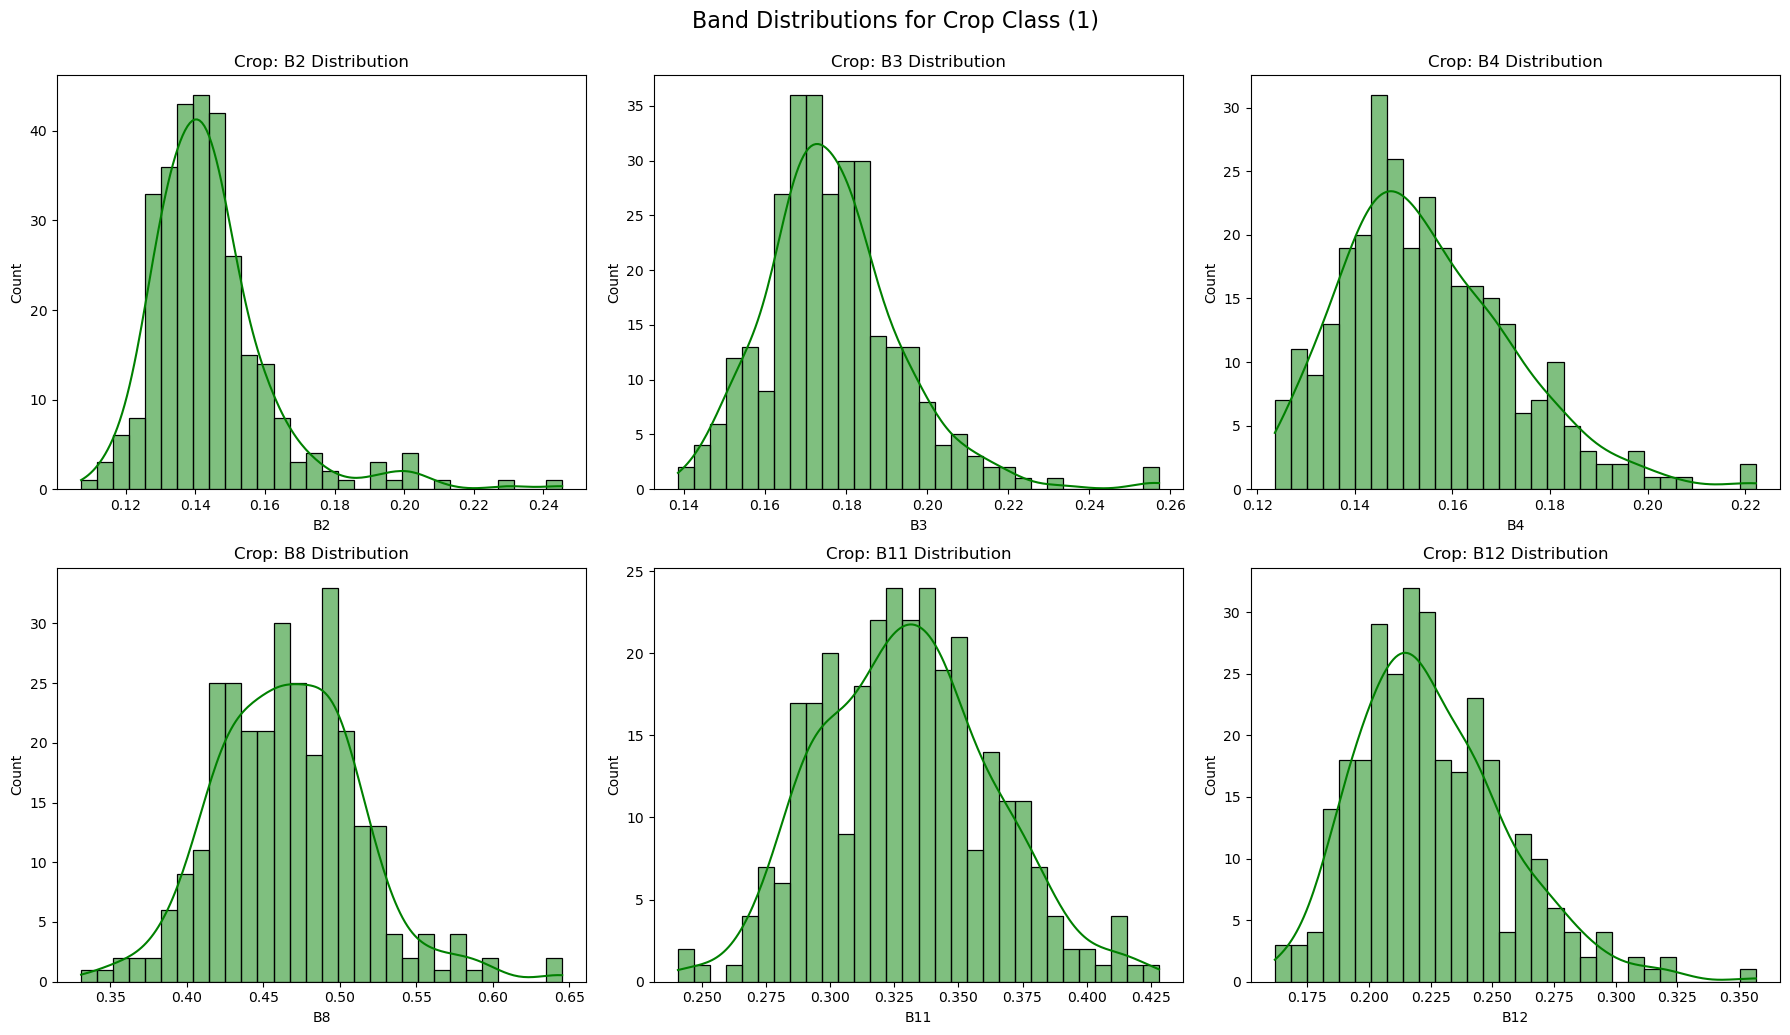

In [12]:
# List of bands
bands = ['B2','B3','B4','B8','B11','B12']

# Separate datasets
df_crop = df[df['class'] == 1]
df_non_crop = df[df['class'] == 0]

# Plot for Class 0 (Non-Crop)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, band in enumerate(bands):
    ax = axes[i]
    sns.histplot(data=df_non_crop, x=band, bins=30, kde=True, color='blue', ax=ax)
    ax.set_title(f"Non-Crop: {band} Distribution")

plt.tight_layout()
plt.suptitle("Band Distributions for Non-Crop Class (0)", fontsize=16, y=1.03)
plt.show()

# Plot for Class 1 (Crop)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, band in enumerate(bands):
    ax = axes[i]
    sns.histplot(data=df_crop, x=band, bins=30, kde=True, color='green', ax=ax)
    ax.set_title(f"Crop: {band} Distribution")

plt.tight_layout()
plt.suptitle("Band Distributions for Crop Class (1)", fontsize=16, y=1.03)
plt.show()

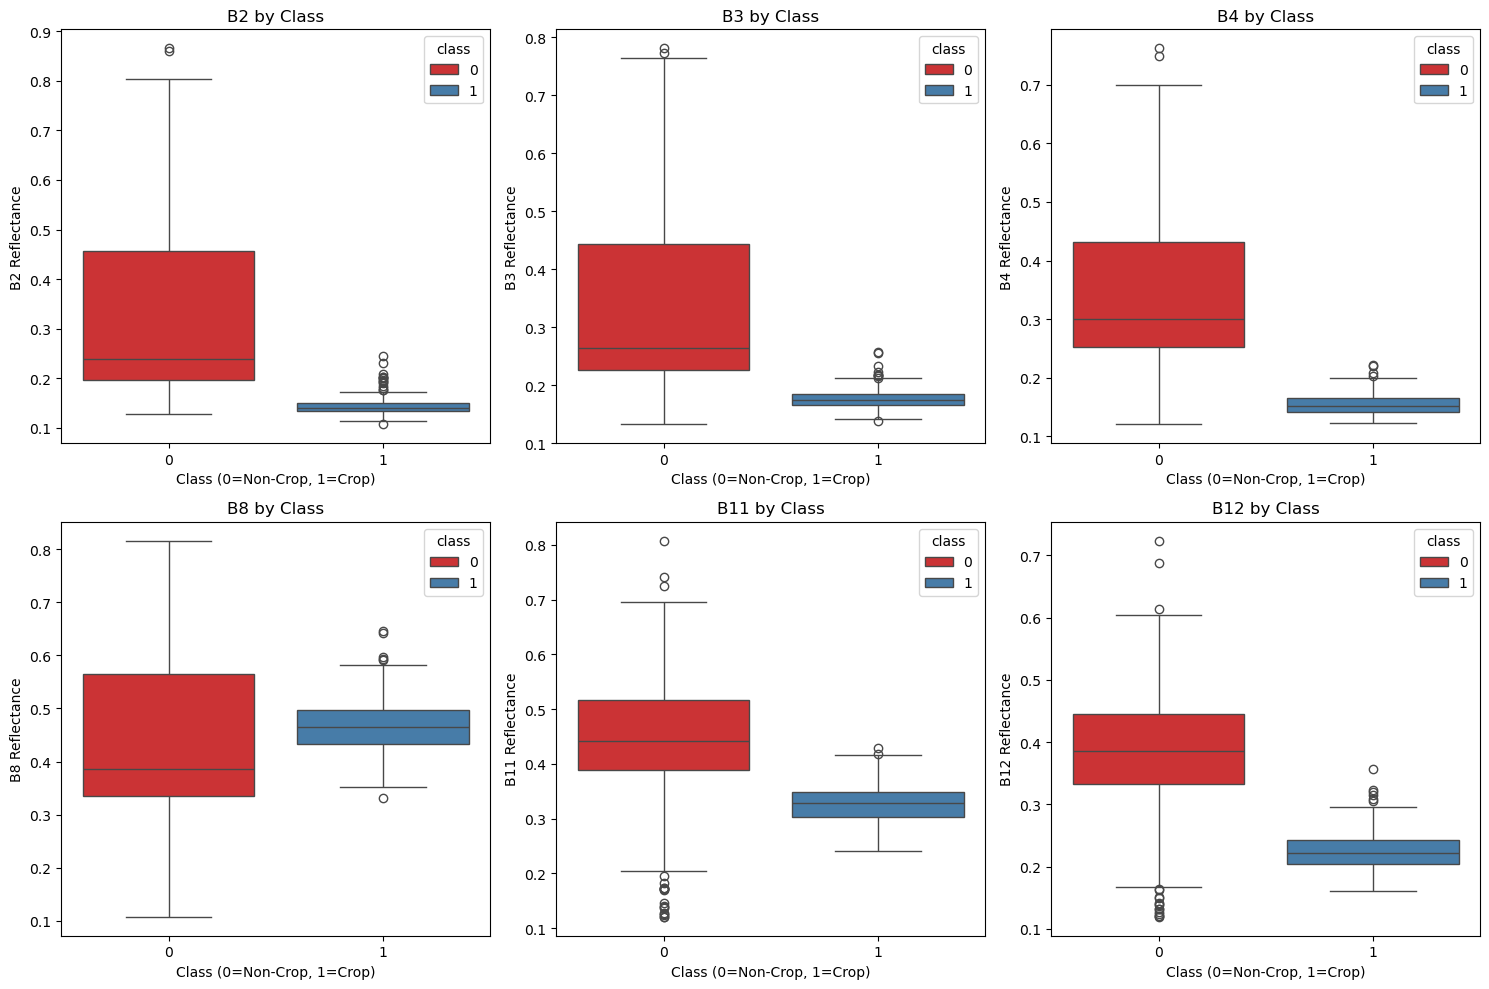

In [13]:
# Box plots to compare spectral values between classes
plt.figure(figsize=(15, 10))
for i, band in enumerate(bands, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='class', hue = 'class', y=band, palette='Set1')
    plt.title(f'{band} by Class')
    plt.xlabel('Class (0=Non-Crop, 1=Crop)')
    plt.ylabel(f'{band} Reflectance')

plt.tight_layout()
plt.show()

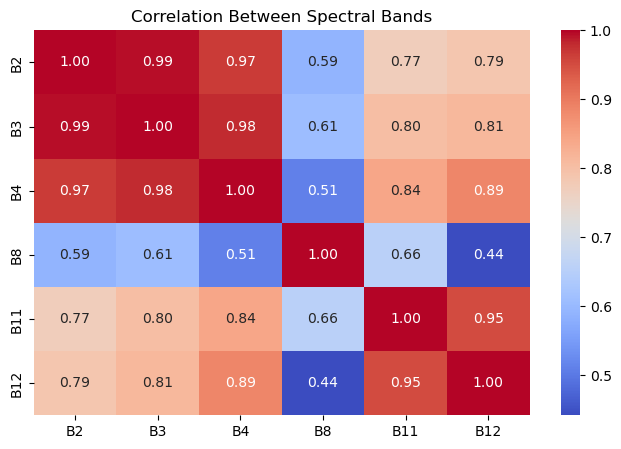

In [14]:
# Correlation plot between Spectral bands
plt.figure(figsize=(8,5))
sns.heatmap(df[bands].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Spectral Bands")
plt.show()

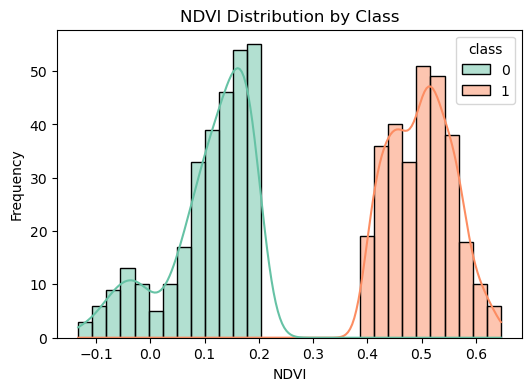

In [15]:
# NDVI Distribution by Class
# NDVI = (NIR - Red) / (NIR + Red)
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])

plt.figure(figsize=(6,4))
sns.histplot(data=df, x="NDVI", hue="class", bins=30, kde=True, palette="Set2")
plt.title("NDVI Distribution by Class")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.show()

<h4 style="color:darkred;">Feature Engineering</h4>

In [16]:
# Feature Engineering
# Create vegetation indices
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])  # Normalized Difference Vegetation Index
df['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8'])  # Normalized Difference Water Index
df['SAVI'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'] + 0.5)) * 1.5  # Soil Adjusted Vegetation Index

# Check new features
print("New features created:")
print(df[['NDVI', 'NDWI', 'SAVI', 'class']].describe())

New features created:
             NDVI        NDWI        SAVI       class
count  600.000000  600.000000  600.000000  600.000000
mean     0.304009   -0.287051    0.257590    0.500000
std      0.207743    0.181461    0.169468    0.500417
min     -0.132889   -0.584295   -0.087323    0.000000
25%      0.130151   -0.445804    0.117490    0.000000
50%      0.300291   -0.335005    0.252379    0.500000
75%      0.501917   -0.144265    0.415123    1.000000
max      0.646086    0.165020    0.589156    1.000000


In [17]:
# Analyze vegetation indices by class
vegetation_indices = ['NDVI', 'NDWI', 'SAVI']

print("Vegetation Indices by Class:")
for index in vegetation_indices:
    print(f"\n{index}:")
    print("Crop (Class 1):")
    print(f"  Mean: {df[df['class']==1][index].mean():.3f}")
    print(f"  Std:  {df[df['class']==1][index].std():.3f}")
    print("Non-Crop (Class 0):")
    print(f"  Mean: {df[df['class']==0][index].mean():.3f}")
    print(f"  Std:  {df[df['class']==0][index].std():.3f}")

Vegetation Indices by Class:

NDVI:
Crop (Class 1):
  Mean: 0.500
  Std:  0.057
Non-Crop (Class 0):
  Mean: 0.108
  Std:  0.079

NDWI:
Crop (Class 1):
  Mean: -0.449
  Std:  0.049
Non-Crop (Class 0):
  Mean: -0.125
  Std:  0.104

SAVI:
Crop (Class 1):
  Mean: 0.416
  Std:  0.056
Non-Crop (Class 0):
  Mean: 0.100
  Std:  0.066


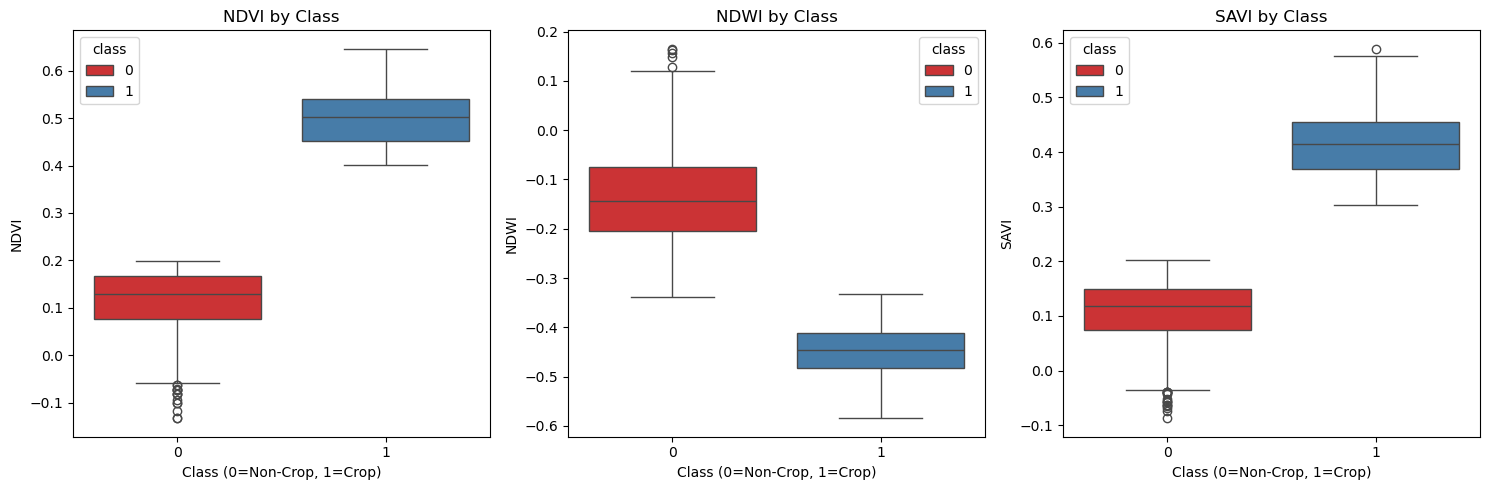

In [18]:
# Visualize vegetation indices
plt.figure(figsize=(15, 5))
for i, index in enumerate(vegetation_indices, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x='class', hue='class', y=index, palette='Set1')
    plt.title(f'{index} by Class')
    plt.xlabel('Class (0=Non-Crop, 1=Crop)')

plt.tight_layout()
plt.show()

In [19]:
# Define features and target
feature_columns = bands + vegetation_indices  # All spectral bands + vegetation indices
X = df[feature_columns]
y = df['class']

print("Feature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)
print("Features used:", feature_columns)

Feature Matrix Shape: (600, 9)
Target Vector Shape: (600,)
Features used: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'SAVI']


<h4 style="color:darkred;">Train-Test-Split</h4>

In [20]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (480, 9)
Test set shape: (120, 9)


<h4 style="color:darkred;">Modeling, Training & Evaluation</h4>

<h5 style="color:darkred;">Random Forest</h5>

In [21]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Results:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Confusion Matrix:
[[60  0]
 [ 0 60]]


In [22]:
# Cross-Validate Random Forest
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


Feature Importance:
  feature  importance
7    NDWI    0.311616
8    SAVI    0.251040
6    NDVI    0.222294
2      B4    0.111893
0      B2    0.043971
1      B3    0.029049
5     B12    0.021417
4     B11    0.005883
3      B8    0.002838


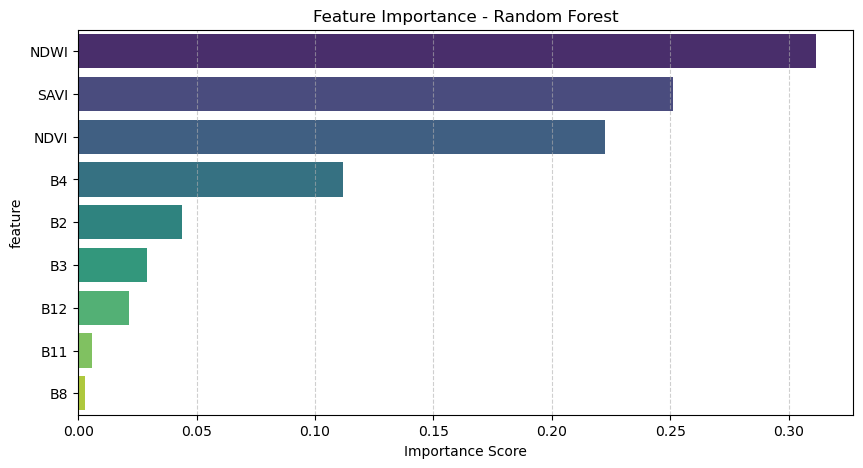

In [23]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='importance', y='feature', hue='feature', palette='viridis', legend=False)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

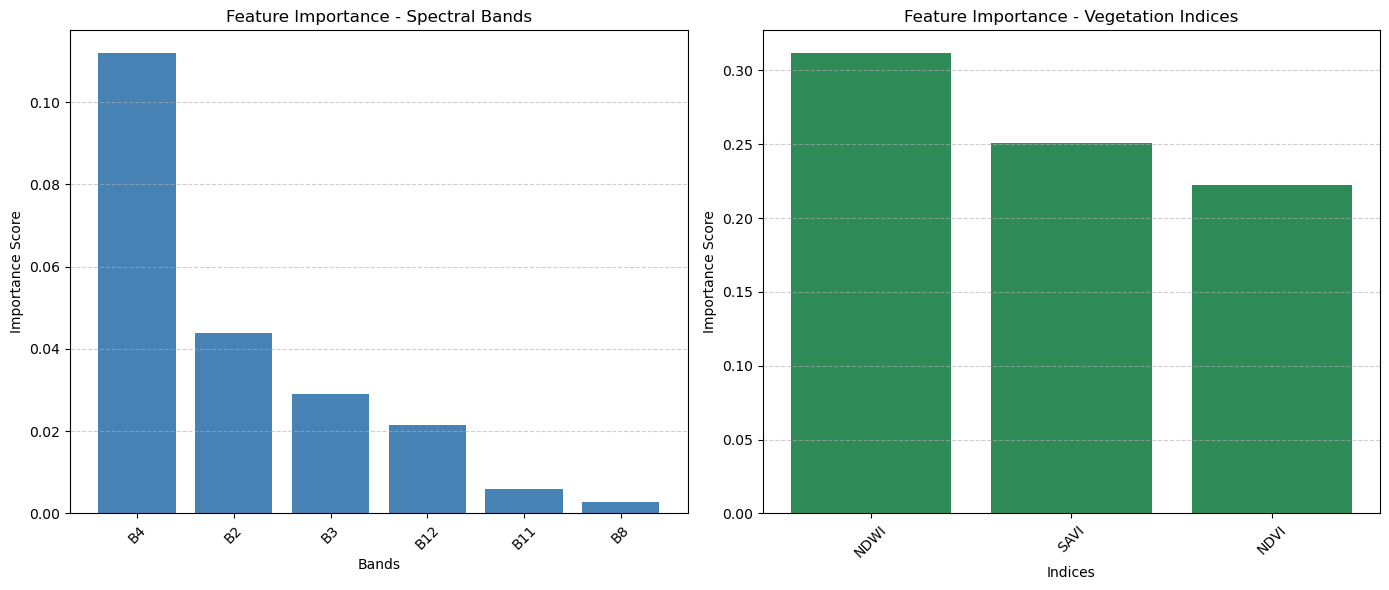

Bands ranking:
feature  importance
     B4    0.111893
     B2    0.043971
     B3    0.029049
    B12    0.021417
    B11    0.005883
     B8    0.002838

Vegetation Indices ranking:
feature  importance
   NDWI    0.311616
   SAVI    0.251040
   NDVI    0.222294


In [24]:
# Analyze feature importances: Type (bands vs indices)
feature_importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})

# Split by type
bands_importance = feature_importances[feature_importances['feature'].isin(bands)]
indices_importance = feature_importances[feature_importances['feature'].isin(vegetation_indices)]

# Sort values for plotting
bands_importance = bands_importance.sort_values('importance', ascending=False)
indices_importance = indices_importance.sort_values('importance', ascending=False)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Spectral Bands
axes[0].bar(bands_importance['feature'], bands_importance['importance'], color='steelblue')
axes[0].set_title("Feature Importance - Spectral Bands")
axes[0].set_ylabel("Importance Score")
axes[0].set_xlabel("Bands")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Vegetation Indices
axes[1].bar(indices_importance['feature'], indices_importance['importance'], color='seagreen')
axes[1].set_title("Feature Importance - Vegetation Indices")
axes[1].set_ylabel("Importance Score")
axes[1].set_xlabel("Indices")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Print rankings
print("Bands ranking:")
print(bands_importance.to_string(index=False))

print("\nVegetation Indices ranking:")
print(indices_importance.to_string(index=False))

<h5 style="color:darkred;">Logistic Regression</h5>

In [25]:
# Train Logistic Regression for comparison
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Confusion Matrix:
[[60  0]
 [ 0 60]]


In [26]:
# Cross-Validate Logistic Regression
cv_scores_lr = cross_val_score(lr_model, X, y, cv=5)
print("Logistic Regression CV scores:", cv_scores_lr)
print("Mean CV Accuracy:", cv_scores_lr.mean())

Logistic Regression CV scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


Investigating Perfect Accuracy
----------------------------------------
Feature Statistics by Class:
B2: Crop=0.144, Non-crop=0.321, Diff=0.177
B3: Crop=0.177, Non-crop=0.333, Diff=0.156
B4: Crop=0.155, Non-crop=0.338, Diff=0.183
B8: Crop=0.467, Non-crop=0.427, Diff=0.040
B11: Crop=0.330, Non-crop=0.431, Diff=0.101
B12: Crop=0.226, Non-crop=0.375, Diff=0.149
NDVI: Crop=0.500, Non-crop=0.108, Diff=0.392
NDWI: Crop=-0.449, Non-crop=-0.125, Diff=0.324
SAVI: Crop=0.416, Non-crop=0.100, Diff=0.316

Check for potential data issues:
Are there any duplicate rows? 0
Are classes perfectly linearly separable?


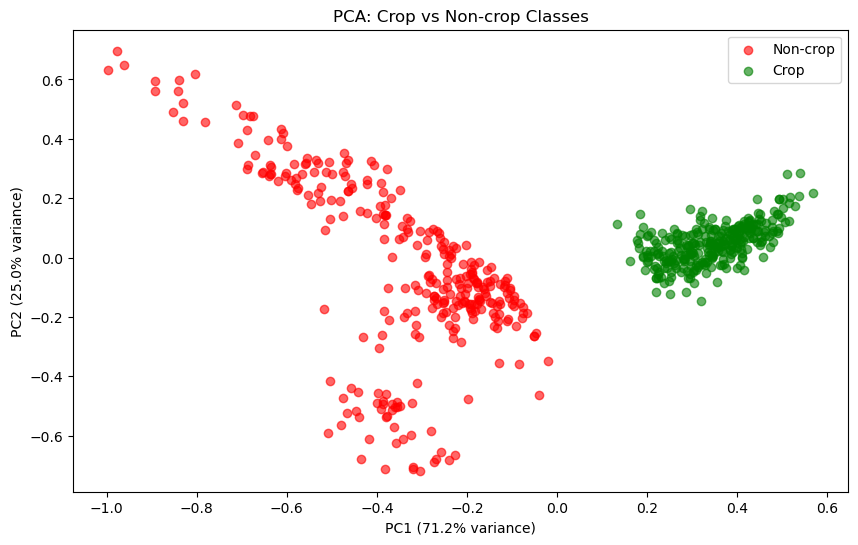


Simple decision tree accuracy: 1.0


In [27]:
# Let's investigate the perfect accuracy
print("Investigating Perfect Accuracy")
print("-"*40)

# Check class separability in feature space
print("Feature Statistics by Class:")
for feature in feature_columns:
    crop_mean = df[df['class']==1][feature].mean()
    non_crop_mean = df[df['class']==0][feature].mean()
    difference = abs(crop_mean - non_crop_mean)
    print(f"{feature}: Crop={crop_mean:.3f}, Non-crop={non_crop_mean:.3f}, Diff={difference:.3f}")

# Check for data leakage - are there any suspicious patterns?
print("\nCheck for potential data issues:")
print("Are there any duplicate rows?", df.duplicated().sum())
print("Are classes perfectly linearly separable?")

# Visualize decision boundary for the top 2 features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], c='red', label='Non-crop', alpha=0.6)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], c='green', label='Crop', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA: Crop vs Non-crop Classes')
plt.legend()
plt.show()

# Test with a simpler model
from sklearn.tree import DecisionTreeClassifier
simple_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
simple_tree.fit(X_train, y_train)
simple_pred = simple_tree.predict(X_test)
print(f"\nSimple decision tree accuracy: {accuracy_score(y_test, simple_pred)}")

In [28]:
# Insight:
# NDVI, SAVI, and NDWI have large mean differences showing a strong vegetation signal.
# The PCA scatterplot shows non-overlapping clusters.
# Even the shallow decision tree hit 100% accuracy, confirming separability.

# Possible reasons for perfect accuracy:
# Excellent data collection: The GEE training points were very well selected.
# Clear spectral differences: Crop and non-crop have very distinct signatures.
# Good feature engineering: Vegetation indices amplify the differences.
# Small dataset: 600 samples might not capture the full variability.
# Homogeneous study area: Limited geographic/seasonal variation.

In [29]:
# # Key Terminologies:
# #Remote Sensing & Spectral Bands
# Sentinel-2 Spectral Bands:
# - Blue Band (B2): Useful for water + atmospheric corrections.                                                     
# - Green Band (B3): Sensitive to vegetation + water features.
# - Red Band (B4): Absorbed by chlorophyll; useful for vegetation analysis.
# - NIR (Near-Infrared, B8): Band sensitive to vegetation health.
# - SWIR (Short-Wave Infrared, B11, B12): Sensitive to soil, moisture, and vegetation water content.

# #Vegetation Indices
# NDVI (Normalized Difference Vegetation Index):
# - Formula: (NIR - Red) / (NIR + Red)
# - Range: -1 to +1
# - Meaning: Measures vegetation greenness and health. Higher values = healthier vegetation
# - Typical values: Water (~-1), Bare soil (~0), Dense vegetation (~0.8-0.9)

# NDWI (Normalized Difference Water Index):
# - Formula: (Green - NIR) / (Green + NIR)
# - Range: -1 to +1
# - Meaning: Detects surface water and vegetation water content
# - Higher values indicate more water content

# SAVI (Soil Adjusted Vegetation Index):
# - Formula: ((NIR - Red) / (NIR + Red + 0.5)) × 1.5
# - Range: -1.5 to +1.5
# - Meaning: Similar to NDVI, but reduces soil background influence
# - Better for sparse vegetation areas